<a href="https://colab.research.google.com/github/danielkennedy1/CS6524_Computer_Vision/blob/main/CelebA_Conv_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Dependencies, Checkpoints, Reproducability

In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import GELU
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import warnings
import kagglehub
from pathlib import Path
from google.colab import drive
from datetime import datetime

warnings.filterwarnings('ignore')

In [2]:
FOLDER_NUMBER = 6 # Change to put checkpoints into different folders
SAMPLE_COUNT = 10_000

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings('ignore')

Using device: cuda


In [4]:
drive.mount('/content/drive')

checkpoint_dir = Path(f'/content/drive/MyDrive/CS6524/VAE_checkpoints_{FOLDER_NUMBER}')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

Mounted at /content/drive


In [5]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [6]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = (image + 1) / 2 # [-1, 1] -> [0, 1]
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

In [7]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Dataset

In [8]:
dataset_path = kagglehub.dataset_download(
    "kushsheth/face-vae",
)

Using Colab cache for faster access to the 'face-vae' dataset.


In [9]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:SAMPLE_COUNT]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [10]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

In [11]:
dataset = CelebADataset(f'{dataset_path}/img_align_celeba/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=768, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 10000
No. of Batches: 14
Sample shape: torch.Size([3, 256, 256])


VERY IMPORTANT: This should be Jim from The Office

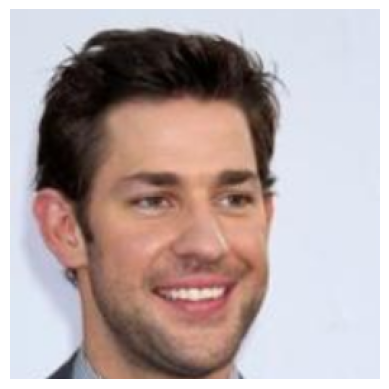

In [12]:
plot_image(dataset[0])

# 2. Variational AutoEncoder

## 2.1 Helpers

In [13]:
def conv_output_size(input_size, kernel_size, stride=1, padding=0):
    return (input_size + 2 * padding - kernel_size) // stride + 1

In [14]:
def convtranspose_output_size(input_size, kernel_size, stride=1, padding=0, output_padding=0):
    return (input_size - 1) * stride - 2 * padding + kernel_size + output_padding

In [15]:
conv_output_size(128, 7, 2, 3)

64

In [16]:
convtranspose_output_size(128, 8, 2, 3)

256

## 2.2 Model

In [17]:
# --- Convolutional VAE ---
class ConvVAE(nn.Module):
    def __init__(self, image_channels: int):
        super().__init__()
        self.image_channels = image_channels

        self.enc = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=7, stride=2, padding=3, bias=False),  # 32x128x128
            nn.GroupNorm(num_groups=32, num_channels=32),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2, bias=False),  # 64x64x64
            nn.GroupNorm(num_groups=32, num_channels=64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),  # 128x32x32
            nn.GroupNorm(num_groups=32, num_channels=128),
            nn.GELU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False),  # 256x16x16
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.GELU(),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2, bias=False),  # 512x8x8
            nn.GroupNorm(num_groups=32, num_channels=512),
        )

        self.enc_mu = nn.Conv2d(512, 8, kernel_size=1, stride=1, padding=0)  # 8x8x8
        self.enc_logvar = nn.Conv2d(512, 8, kernel_size=1, stride=1, padding=0)  # 8x8x8


        self.dec = nn.Sequential(
            nn.ConvTranspose2d(8, 512, kernel_size=1, stride=1, padding=0),  # 512x8x8
            nn.GroupNorm(num_groups=32, num_channels=512),
            nn.GELU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 256x16x16
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.GELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128x32x32
            nn.GroupNorm(num_groups=32, num_channels=128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x64x64
            nn.GroupNorm(num_groups=32, num_channels=64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x128x128
            nn.GroupNorm(num_groups=32, num_channels=32),
            nn.GELU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=8, stride=2, padding=3),  # 3x256x256
            nn.Tanh(),
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z_vec):
        x_recon = self.dec(z_vec)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z_vec = self.reparameterize(mu, logvar)
        x_recon = self.decode(z_vec)
        return x_recon, mu, logvar

vae = ConvVAE(image_channels=3).to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("VAE parameters (M):", sum(p.numel() for p in vae.parameters())/1e6)
print(vae)


VAE parameters (M): 7.165395
ConvVAE(
  (enc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): GroupNorm(32, 32, eps=1e-05, affine=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): GroupNorm(32, 64, eps=1e-05, affine=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): GroupNorm(32, 128, eps=1e-05, affine=True)
    (8): GELU(approximate='none')
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (10): GroupNorm(32, 256, eps=1e-05, affine=True)
    (11): GELU(approximate='none')
    (12): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (13): GroupNorm(32, 512, eps=1e-05, affine=True)
  )
  (enc_mu): Conv2d(512, 8, kernel_size=(1, 1), stride=(1, 1))
  (enc_logvar): Conv2d(512, 8, kernel_

## 2.3 Loss Function

KL annealing: start by scaling the regularization loss from 0, then step it up until it gets to 1 at a certain point in the training

In [18]:
# KL annealinng
def get_kl_weight(epoch, warmup_epochs=20):
    return min(1.0, epoch / warmup_epochs)

def vae_loss(x_recon, x, mu, logvar, epoch):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + get_kl_weight(epoch) * kl, recon_loss, kl, get_kl_weight(epoch)

## 2.4 Training

In [20]:
num_vae_epochs = 50

sum_loss_history = []
recon_loss_history = []
kl_loss_history = []

vae.train()
for epoch in range(num_vae_epochs):
    pbar = tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{num_vae_epochs}")

    total_sum_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.00
    total_kl_loss = 0.0

    for imgs in pbar:
        imgs = imgs.to(device)
        x_recon, mu, logvar = vae(imgs)
        loss, r_loss, kl, kl_scale_factor = vae_loss(x_recon, imgs, mu, logvar, epoch)

        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()

        total_sum_loss += loss.item() * imgs.size(0)
        total_recon_loss += r_loss.item() * imgs.size(0)
        total_kl_loss += kl.item() * imgs.size(0)
        pbar.set_postfix({"loss": loss.item(), "recon": r_loss.item(), "kl": kl.item(), "kl_scale_factor": kl_scale_factor})

    save_checkpoint(vae, vae_opt, epoch, loss, checkpoint_dir / 'vae.pt')

    sum_loss_history.append(total_sum_loss / len(dataset))
    recon_loss_history.append(total_recon_loss / len(dataset))
    kl_loss_history.append(total_kl_loss / len(dataset))

    print(f"Epoch {epoch+1}: avg loss = {total_sum_loss/len(dataset):.4f}\n")


VAE Epoch 1/50: 100%|██████████| 14/14 [01:18<00:00,  5.61s/it, loss=5.9e+4, recon=5.9e+4, kl=1.73e+9, kl_scale_factor=0]


Epoch 1: avg loss = 64589.3413



VAE Epoch 2/50: 100%|██████████| 14/14 [00:40<00:00,  2.87s/it, loss=6.3e+4, recon=6.16e+4, kl=2.88e+4, kl_scale_factor=0.05]


Epoch 2: avg loss = 1995793.0731



VAE Epoch 3/50: 100%|██████████| 14/14 [00:39<00:00,  2.80s/it, loss=5.64e+4, recon=5.56e+4, kl=8.04e+3, kl_scale_factor=0.1]


Epoch 3: avg loss = 54128.2795



VAE Epoch 4/50: 100%|██████████| 14/14 [00:39<00:00,  2.80s/it, loss=4.53e+4, recon=4.47e+4, kl=4.23e+3, kl_scale_factor=0.15]


Epoch 4: avg loss = 46585.8796



VAE Epoch 5/50: 100%|██████████| 14/14 [00:39<00:00,  2.83s/it, loss=3.94e+4, recon=3.86e+4, kl=3.98e+3, kl_scale_factor=0.2]


Epoch 5: avg loss = 42197.3146



VAE Epoch 6/50: 100%|██████████| 14/14 [00:39<00:00,  2.85s/it, loss=3e+4, recon=2.92e+4, kl=3.38e+3, kl_scale_factor=0.25]


Epoch 6: avg loss = 39222.2272



VAE Epoch 7/50: 100%|██████████| 14/14 [00:39<00:00,  2.80s/it, loss=3.07e+4, recon=2.97e+4, kl=3.29e+3, kl_scale_factor=0.3]


Epoch 7: avg loss = 36326.5577



VAE Epoch 8/50: 100%|██████████| 14/14 [00:39<00:00,  2.84s/it, loss=3.21e+4, recon=3.12e+4, kl=2.51e+3, kl_scale_factor=0.35]


Epoch 8: avg loss = 33572.4727



VAE Epoch 9/50: 100%|██████████| 14/14 [00:39<00:00,  2.83s/it, loss=3.41e+4, recon=3.32e+4, kl=2.4e+3, kl_scale_factor=0.4]


Epoch 9: avg loss = 30998.2100



VAE Epoch 10/50: 100%|██████████| 14/14 [00:39<00:00,  2.80s/it, loss=2.59e+4, recon=2.49e+4, kl=2.26e+3, kl_scale_factor=0.45]


Epoch 10: avg loss = 29377.6513



VAE Epoch 11/50: 100%|██████████| 14/14 [00:40<00:00,  2.90s/it, loss=2.94e+4, recon=2.83e+4, kl=2.05e+3, kl_scale_factor=0.5]


Epoch 11: avg loss = 26721.4130



VAE Epoch 12/50: 100%|██████████| 14/14 [00:40<00:00,  2.90s/it, loss=2.44e+4, recon=2.34e+4, kl=1.79e+3, kl_scale_factor=0.55]


Epoch 12: avg loss = 26478.0874



VAE Epoch 13/50: 100%|██████████| 14/14 [00:40<00:00,  2.91s/it, loss=2.89e+4, recon=2.78e+4, kl=1.76e+3, kl_scale_factor=0.6]


Epoch 13: avg loss = 26668.3474



VAE Epoch 14/50: 100%|██████████| 14/14 [00:40<00:00,  2.86s/it, loss=2.39e+4, recon=2.28e+4, kl=1.57e+3, kl_scale_factor=0.65]


Epoch 14: avg loss = 24278.9765



VAE Epoch 15/50: 100%|██████████| 14/14 [00:40<00:00,  2.91s/it, loss=2.41e+4, recon=2.31e+4, kl=1.47e+3, kl_scale_factor=0.7]


Epoch 15: avg loss = 23226.5001



VAE Epoch 16/50: 100%|██████████| 14/14 [00:41<00:00,  2.98s/it, loss=2.15e+4, recon=2.04e+4, kl=1.42e+3, kl_scale_factor=0.75]


Epoch 16: avg loss = 22619.2986



VAE Epoch 17/50: 100%|██████████| 14/14 [00:40<00:00,  2.87s/it, loss=1.79e+4, recon=1.68e+4, kl=1.35e+3, kl_scale_factor=0.8]


Epoch 17: avg loss = 22124.4155



VAE Epoch 18/50: 100%|██████████| 14/14 [00:40<00:00,  2.86s/it, loss=2.31e+4, recon=2.2e+4, kl=1.25e+3, kl_scale_factor=0.85]


Epoch 18: avg loss = 21983.7270



VAE Epoch 19/50: 100%|██████████| 14/14 [00:40<00:00,  2.87s/it, loss=2.19e+4, recon=2.07e+4, kl=1.25e+3, kl_scale_factor=0.9]


Epoch 19: avg loss = 22070.1464



VAE Epoch 20/50: 100%|██████████| 14/14 [00:39<00:00,  2.84s/it, loss=2.46e+4, recon=2.35e+4, kl=1.17e+3, kl_scale_factor=0.95]


Epoch 20: avg loss = 20980.6212



VAE Epoch 21/50: 100%|██████████| 14/14 [00:40<00:00,  2.89s/it, loss=2.34e+4, recon=2.22e+4, kl=1.17e+3, kl_scale_factor=1]


Epoch 21: avg loss = 20762.0008



VAE Epoch 22/50: 100%|██████████| 14/14 [00:39<00:00,  2.85s/it, loss=2.18e+4, recon=2.07e+4, kl=1.09e+3, kl_scale_factor=1]


Epoch 22: avg loss = 20210.1165



VAE Epoch 23/50: 100%|██████████| 14/14 [00:39<00:00,  2.85s/it, loss=1.9e+4, recon=1.79e+4, kl=1.13e+3, kl_scale_factor=1]


Epoch 23: avg loss = 20734.7703



VAE Epoch 24/50: 100%|██████████| 14/14 [00:40<00:00,  2.86s/it, loss=2.75e+4, recon=2.64e+4, kl=1.07e+3, kl_scale_factor=1]


Epoch 24: avg loss = 19560.7261



VAE Epoch 25/50: 100%|██████████| 14/14 [00:39<00:00,  2.85s/it, loss=1.73e+4, recon=1.62e+4, kl=1.08e+3, kl_scale_factor=1]


Epoch 25: avg loss = 19560.6753



VAE Epoch 26/50: 100%|██████████| 14/14 [00:40<00:00,  2.89s/it, loss=2.02e+4, recon=1.92e+4, kl=1.01e+3, kl_scale_factor=1]


Epoch 26: avg loss = 19382.0256



VAE Epoch 27/50: 100%|██████████| 14/14 [00:41<00:00,  2.93s/it, loss=1.67e+4, recon=1.56e+4, kl=1.06e+3, kl_scale_factor=1]


Epoch 27: avg loss = 18571.2721



VAE Epoch 28/50: 100%|██████████| 14/14 [00:40<00:00,  2.88s/it, loss=1.61e+4, recon=1.5e+4, kl=1.04e+3, kl_scale_factor=1]


Epoch 28: avg loss = 18178.5610



VAE Epoch 29/50: 100%|██████████| 14/14 [00:40<00:00,  2.90s/it, loss=1.74e+4, recon=1.63e+4, kl=1.07e+3, kl_scale_factor=1]


Epoch 29: avg loss = 17795.1156



VAE Epoch 30/50: 100%|██████████| 14/14 [00:39<00:00,  2.82s/it, loss=1.68e+4, recon=1.58e+4, kl=1.02e+3, kl_scale_factor=1]


Epoch 30: avg loss = 18074.6862



VAE Epoch 31/50:   7%|▋         | 1/14 [00:06<01:18,  6.01s/it, loss=1.88e+4, recon=1.78e+4, kl=1.01e+3, kl_scale_factor=1]


KeyboardInterrupt: 

## 2.5 Loading from Checkpoint

In [21]:
epoch, _ = load_checkpoint(vae, vae_opt, checkpoint_dir / 'vae.pt')

In [22]:
epoch

29

## 2.6 Example reconstruction

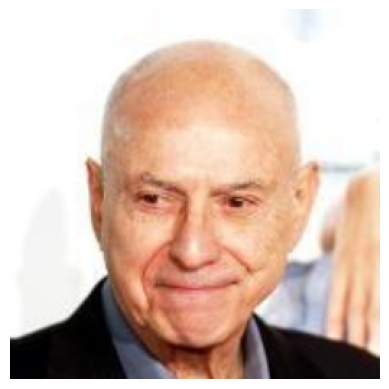

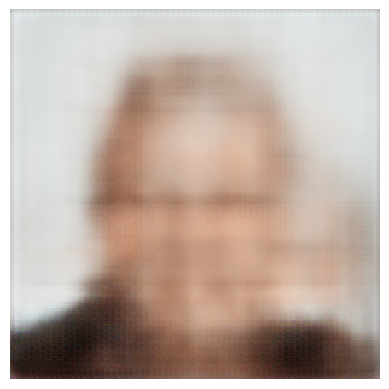

In [23]:
vae.eval()

imgs = next(iter(dataloader))
imgs = imgs.to(device)[:8]
with torch.no_grad():
    recon, _, _ = vae(imgs)

plot_image(imgs[0])
plot_image(recon[0])

# 3. Latent Diffuser (ordinary)

## 3.1 Hyperparameters

In [ ]:
T = 250 # No. of steps
diffusion_lr = 2e-4

In [ ]:
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)

def q_sample(z0, t, noise=None):
    """Applies noise at time step t to z0 (batch, latent_dim)"""
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1)
    sqrt_one_minus = torch.sqrt(1.0 - alphas_cumprod[t]).view(-1, 1)
    return sqrt_alpha_bar * z0 + sqrt_one_minus * noise

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, dim):
        super().__init__()
        self.emb = nn.Embedding(T, dim)

    def forward(self, t):
        return self.emb(t)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, dim, time_dim):
        super().__init__()

        self.time_mlp = nn.Linear(time_dim, dim)

        self.lin1 = nn.Linear(dim, dim)
        self.act = nn.ReLU()
        self.lin2 = nn.Linear(dim + time_dim, dim)

        self.res_lin = nn.Linear(dim, dim)

    def forward(self, x, t_emb):
        h = self.lin1(x)
        time_emb = self.time_mlp(t_emb)
        x = torch.cat([h, t_emb], dim=1)
        x = self.lin2(x)
        x = self.act(x)
        return x + self.res_lin(h)

class LatentDDPM(nn.Module):
    def __init__(self, latent_dim: int, time_dim: int, hidden_dim: int, T: int):
        super().__init__()

        self.time_mlp = nn.Sequential(
            TimeEmbedding(T, time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        self.proj_in = nn.Linear(latent_dim + time_dim, hidden_dim)

        self.resblock1 = ResBlock(hidden_dim, time_dim)
        self.resblock2 = ResBlock(hidden_dim, time_dim)

        self.proj_out = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_t, t):
        t_emb = self.time_mlp(t)
        x = torch.cat([z_t, t_emb], dim=1)
        x = self.proj_in(x)
        x = F.relu(x)
        x = self.resblock1(x, t_emb)
        x = self.resblock2(x, t_emb)
        x = self.proj_out(x)
        return x

In [ ]:
diffusion_model = LatentDDPM(
    latent_dim=512,
    time_dim=256,
    hidden_dim=1024,
    T=T
).to(device)

diffusion_optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=diffusion_lr)

print("Diffusion parameters (M):", sum(p.numel() for p in diffusion_model.parameters())/1e6)
print(diffusion_model)

Diffusion parameters (M): 9.250048
LatentDDPM(
  (time_mlp): Sequential(
    (0): TimeEmbedding(
      (emb): Embedding(250, 256)
    )
    (1): Linear(in_features=256, out_features=1024, bias=True)
    (2): SiLU()
    (3): Linear(in_features=1024, out_features=256, bias=True)
  )
  (proj_in): Linear(in_features=768, out_features=1024, bias=True)
  (resblock1): ResBlock(
    (time_mlp): Linear(in_features=256, out_features=1024, bias=True)
    (lin1): Linear(in_features=1024, out_features=1024, bias=True)
    (act): ReLU()
    (lin2): Linear(in_features=1280, out_features=1024, bias=True)
    (res_lin): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (resblock2): ResBlock(
    (time_mlp): Linear(in_features=256, out_features=1024, bias=True)
    (lin1): Linear(in_features=1024, out_features=1024, bias=True)
    (act): ReLU()
    (lin2): Linear(in_features=1280, out_features=1024, bias=True)
    (res_lin): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (proj_o

In [ ]:
dataloader_diffusion = DataLoader(dataset, batch_size=2048, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader_diffusion)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 50000
No. of Batches: 25
Sample shape: torch.Size([3, 256, 256])


In [ ]:
diffusion_epochs = 50

diffusion_model.train()

for epoch in range(diffusion_epochs):
    total_loss = 0.0
    n_batches = 0

    pbar = tqdm(dataloader_diffusion, desc=f"Latent Diffuser Epoch {epoch+1}/{diffusion_epochs}")

    for x in pbar:
        x = x.to(device)
        batch_size = x.size(0)

        with torch.no_grad():
            mu, logvar = vae.encode(x)
            z0 = mu

        t = torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)

        noise = torch.randn_like(z0)
        z_t = q_sample(z0, t, noise=noise)

        eps_pred = diffusion_model(z_t, t)

        loss = F.mse_loss(eps_pred, noise)

        pbar.set_postfix({"loss": loss.item()})

        diffusion_optimizer.zero_grad()
        loss.backward()
        diffusion_optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    save_checkpoint(diffusion_model, diffusion_optimizer, epoch, loss, checkpoint_dir / 'ordinary_diffuser.pt')

    avg_loss = total_loss / n_batches
    print(f"Epoch {epoch + 1:02d} | MSE loss: {avg_loss:.6f}")

Latent Diffuser Epoch 1/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.936]


Epoch 01 | MSE loss: 0.977231


Latent Diffuser Epoch 2/50: 100%|██████████| 25/25 [02:34<00:00,  6.16s/it, loss=0.845]


Epoch 02 | MSE loss: 0.888713


Latent Diffuser Epoch 3/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it, loss=0.792]


Epoch 03 | MSE loss: 0.812814


Latent Diffuser Epoch 4/50: 100%|██████████| 25/25 [02:31<00:00,  6.07s/it, loss=0.75]


Epoch 04 | MSE loss: 0.758638


Latent Diffuser Epoch 5/50: 100%|██████████| 25/25 [02:32<00:00,  6.09s/it, loss=0.689]


Epoch 05 | MSE loss: 0.713978


Latent Diffuser Epoch 6/50: 100%|██████████| 25/25 [02:32<00:00,  6.09s/it, loss=0.658]


Epoch 06 | MSE loss: 0.678523


Latent Diffuser Epoch 7/50: 100%|██████████| 25/25 [02:33<00:00,  6.12s/it, loss=0.647]


Epoch 07 | MSE loss: 0.649392


Latent Diffuser Epoch 8/50: 100%|██████████| 25/25 [02:32<00:00,  6.10s/it, loss=0.613]


Epoch 08 | MSE loss: 0.624160


Latent Diffuser Epoch 9/50: 100%|██████████| 25/25 [02:32<00:00,  6.10s/it, loss=0.593]


Epoch 09 | MSE loss: 0.602586


Latent Diffuser Epoch 10/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it, loss=0.579]


Epoch 10 | MSE loss: 0.584728


Latent Diffuser Epoch 11/50: 100%|██████████| 25/25 [02:33<00:00,  6.16s/it, loss=0.575]


Epoch 11 | MSE loss: 0.567862


Latent Diffuser Epoch 12/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.545]


Epoch 12 | MSE loss: 0.555281


Latent Diffuser Epoch 13/50: 100%|██████████| 25/25 [02:32<00:00,  6.11s/it, loss=0.535]


Epoch 13 | MSE loss: 0.543934


Latent Diffuser Epoch 14/50: 100%|██████████| 25/25 [02:32<00:00,  6.12s/it, loss=0.525]


Epoch 14 | MSE loss: 0.533445


Latent Diffuser Epoch 15/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.518]


Epoch 15 | MSE loss: 0.523199


Latent Diffuser Epoch 16/50: 100%|██████████| 25/25 [02:32<00:00,  6.12s/it, loss=0.515]


Epoch 16 | MSE loss: 0.515073


Latent Diffuser Epoch 17/50: 100%|██████████| 25/25 [02:33<00:00,  6.12s/it, loss=0.503]


Epoch 17 | MSE loss: 0.509128


Latent Diffuser Epoch 18/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.501]


Epoch 18 | MSE loss: 0.502240


Latent Diffuser Epoch 19/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.503]


Epoch 19 | MSE loss: 0.498812


Latent Diffuser Epoch 20/50: 100%|██████████| 25/25 [02:32<00:00,  6.09s/it, loss=0.487]


Epoch 20 | MSE loss: 0.493937


Latent Diffuser Epoch 21/50: 100%|██████████| 25/25 [02:31<00:00,  6.08s/it, loss=0.481]


Epoch 21 | MSE loss: 0.487641


Latent Diffuser Epoch 22/50: 100%|██████████| 25/25 [02:33<00:00,  6.15s/it, loss=0.47]


Epoch 22 | MSE loss: 0.483657


Latent Diffuser Epoch 23/50: 100%|██████████| 25/25 [02:32<00:00,  6.11s/it, loss=0.472]


Epoch 23 | MSE loss: 0.478741


Latent Diffuser Epoch 24/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it, loss=0.481]


Epoch 24 | MSE loss: 0.474906


Latent Diffuser Epoch 25/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.467]


Epoch 25 | MSE loss: 0.471275


Latent Diffuser Epoch 26/50: 100%|██████████| 25/25 [02:33<00:00,  6.15s/it, loss=0.467]


Epoch 26 | MSE loss: 0.469131


Latent Diffuser Epoch 27/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it, loss=0.462]


Epoch 27 | MSE loss: 0.464727


Latent Diffuser Epoch 28/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it, loss=0.459]


Epoch 28 | MSE loss: 0.462994


Latent Diffuser Epoch 29/50: 100%|██████████| 25/25 [02:33<00:00,  6.12s/it, loss=0.446]


Epoch 29 | MSE loss: 0.461246


Latent Diffuser Epoch 30/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.45]


Epoch 30 | MSE loss: 0.457495


Latent Diffuser Epoch 31/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.45]


Epoch 31 | MSE loss: 0.454299


Latent Diffuser Epoch 32/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.46]


Epoch 32 | MSE loss: 0.453800


Latent Diffuser Epoch 33/50: 100%|██████████| 25/25 [02:32<00:00,  6.09s/it, loss=0.456]


Epoch 33 | MSE loss: 0.451650


Latent Diffuser Epoch 34/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.433]


Epoch 34 | MSE loss: 0.447366


Latent Diffuser Epoch 35/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.446]


Epoch 35 | MSE loss: 0.448503


Latent Diffuser Epoch 36/50: 100%|██████████| 25/25 [02:32<00:00,  6.11s/it, loss=0.441]


Epoch 36 | MSE loss: 0.443774


Latent Diffuser Epoch 37/50: 100%|██████████| 25/25 [02:32<00:00,  6.10s/it, loss=0.43]


Epoch 37 | MSE loss: 0.441277


Latent Diffuser Epoch 38/50: 100%|██████████| 25/25 [02:32<00:00,  6.10s/it, loss=0.44]


Epoch 38 | MSE loss: 0.440497


Latent Diffuser Epoch 39/50: 100%|██████████| 25/25 [02:35<00:00,  6.21s/it, loss=0.433]


Epoch 39 | MSE loss: 0.439770


Latent Diffuser Epoch 40/50: 100%|██████████| 25/25 [02:35<00:00,  6.21s/it, loss=0.441]


Epoch 40 | MSE loss: 0.439248


Latent Diffuser Epoch 41/50: 100%|██████████| 25/25 [02:33<00:00,  6.15s/it, loss=0.418]


Epoch 41 | MSE loss: 0.434418


Latent Diffuser Epoch 42/50: 100%|██████████| 25/25 [02:32<00:00,  6.09s/it, loss=0.433]


Epoch 42 | MSE loss: 0.434457


Latent Diffuser Epoch 43/50: 100%|██████████| 25/25 [02:33<00:00,  6.13s/it, loss=0.417]


Epoch 43 | MSE loss: 0.432397


Latent Diffuser Epoch 44/50: 100%|██████████| 25/25 [02:32<00:00,  6.11s/it, loss=0.428]


Epoch 44 | MSE loss: 0.432631


Latent Diffuser Epoch 45/50: 100%|██████████| 25/25 [02:32<00:00,  6.10s/it, loss=0.446]


Epoch 45 | MSE loss: 0.433573


Latent Diffuser Epoch 46/50: 100%|██████████| 25/25 [02:33<00:00,  6.15s/it, loss=0.438]


Epoch 46 | MSE loss: 0.430668


Latent Diffuser Epoch 47/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it, loss=0.431]


Epoch 47 | MSE loss: 0.430418


Latent Diffuser Epoch 48/50: 100%|██████████| 25/25 [02:34<00:00,  6.19s/it, loss=0.418]


Epoch 48 | MSE loss: 0.426615


Latent Diffuser Epoch 49/50: 100%|██████████| 25/25 [02:34<00:00,  6.18s/it, loss=0.433]


Epoch 49 | MSE loss: 0.424708


Latent Diffuser Epoch 50/50: 100%|██████████| 25/25 [02:34<00:00,  6.19s/it, loss=0.418]


Epoch 50 | MSE loss: 0.425322


In [ ]:
epoch, loss = load_checkpoint(diffusion_model, diffusion_optimizer, checkpoint_dir / 'ordinary_diffuser.pt')
print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 49, Loss: 0.418178528547287


In [ ]:
@torch.no_grad()
def p_sample_step(z_t, t):
    b = z_t.size(0)
    t_tensor = torch.full((b,), t, device=device, dtype=torch.long)
    eps_pred = diffusion_model(z_t, t_tensor)

    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alphas_cumprod[t]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)

    z0_est = (z_t - sqrt_one_minus_alpha_bar_t * eps_pred) / torch.sqrt(alpha_bar_t)

    if t > 0:
        alpha_bar_prev = alphas_cumprod[t - 1]
        coef1 = torch.sqrt(alpha_bar_prev) * beta_t / (1.0 - alpha_bar_t)
        coef2 = torch.sqrt(alpha_t) * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        mean = coef1 * z0_est + coef2 * z_t
        var = beta_t * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        noise = torch.randn_like(z_t)
        z_prev = mean + torch.sqrt(var) * noise
    else:
        z_prev = z0_est
    return z_prev


@torch.no_grad()
def sample_latent_and_decode(n_samples=16):
    diffusion_model.eval()
    vae.eval()

    z_t = torch.randn(n_samples, 512, device=device)

    for t in reversed(range(T)):
        z_t = p_sample_step(z_t, t)

    x_hat_flat = vae.decode(z_t)
    x_hat = x_hat_flat.view(-1, 3, 256, 256)
    return x_hat.cpu()

In [ ]:
samples = sample_latent_and_decode(n_samples=5)

In [ ]:
samples.shape

torch.Size([5, 3, 256, 256])

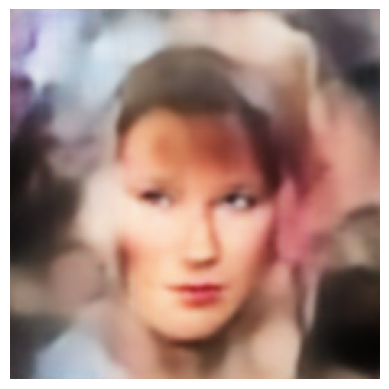

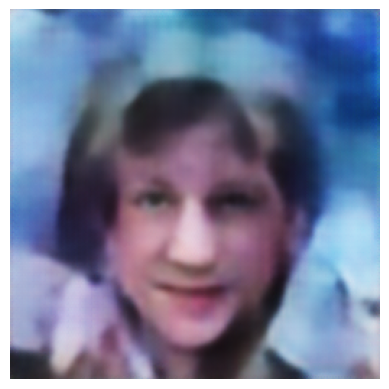

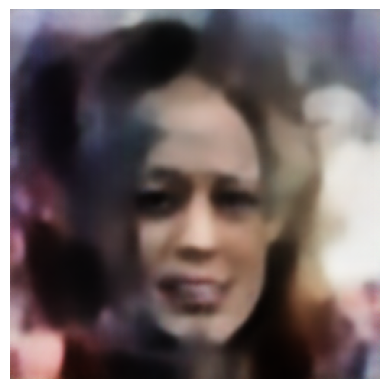

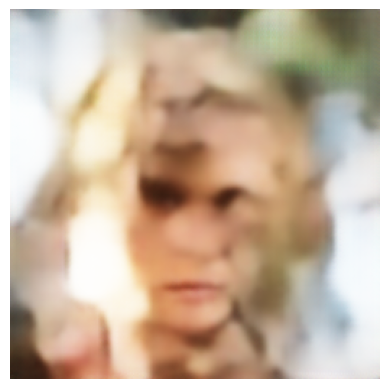

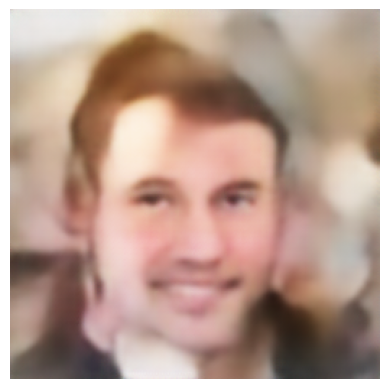

In [ ]:
for image in samples:
  plot_image(image)